In [98]:
import pickle
import gc
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine

from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss

from tqdm import tqdm
import lightgbm as lgb
def load(name, dir_path="../data/"):
    with open('%s.p' % name, 'rb') as fp:
        return pickle.load(fp)

In [99]:
max_features = 100000
def load_glove(word_index):
    EMBEDDING_FILE = './glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words+1, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is None and ',' in word:
            emb = []
            for w in word.split(','):
                emb.append(embeddings_index.get(w))
            if all(x is not None for x in emb):
                    embedding_vector = np.mean(np.array(emb), axis=0)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    return embedding_matrix 
    
def load_fasttext(word_index):    
    EMBEDDING_FILE = './wiki-news-300d-1M/wiki-news-300d-1M.vec'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words+1, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is None and ',' in word:
            emb = []
            for w in word.split(','):
                emb.append(embeddings_index.get(w))
            if all(x is not None for x in emb):
                embedding_vector = np.mean(np.array(emb), axis=0)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

def load_para(word_index):
    EMBEDDING_FILE = './paragram_300_sl999/paragram_300_sl999.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words+1, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is None and ',' in word:
            emb = []
            for w in word.split(','):
                emb.append(embeddings_index.get(w))
            if all(x is not None for x in emb):
                embedding_vector = np.mean(np.array(emb), axis=0)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

def load_word2vec(word_index):
    embeddings_index = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin', binary=True)
    
    all_embs = np.stack(embeddings_index.syn0)
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    oov = []
    for word, i in word_index.items():
        if i >= max_features: continue
        try:
            if ',' in word:
                emb = []
                for w in word.split(','):
                    emb.append(embeddings_index.get(w))
                if all(x is not None for x in emb):
                    embedding_vector = np.mean(np.array(emb), axis=0)
            embedding_matrix[i] = embeddings_index.get_vector(word)
        except Exception as err:
#             print(err, word)
            oov.append(word)
            
    del embeddings_index, all_embs
    import gc; gc.collect()
    
    return embedding_matrix, oov

In [160]:
train = pd.read_csv('new_train_2.csv')
train.dropna(inplace=True)
test = pd.read_csv('new_test_2.csv')

# Prepare data
def clean_word(x):
    x_clean = ''.join(e for e in x if e.isalnum())
    return x_clean

def clean(df):
    df['word1_clean'] = df['word1'].apply(lambda x: clean_word(x))
    df['word2_clean'] = df['word2'].apply(lambda x: clean_word(x))

clean(train)
clean(test)

In [101]:
all_data = pd.concat([train, test])
tokens = set(list(all_data['word1_clean'].unique())+ list(all_data['word2_clean'].unique()))
word_index = {k: v for v, k in enumerate(tokens)}

In [102]:
embedding_matrix_para = load_para(word_index)

In [103]:
embedding_matrix_glove = load_glove(word_index)

In [104]:
embedding_matrix_fasttext = load_fasttext(word_index)

In [105]:
definitions = pd.read_csv('definitions.csv.zip')
definitions.definitions.fillna(' ', inplace=True)
definitions.definitions = definitions.definitions.map(lambda x: x.replace('|', ' '))
definitions.definitions = definitions.definitions.map(lambda x: x.replace('(', ' '))
definitions.definitions = definitions.definitions.map(lambda x: x.replace(')', ' '))
tk = Tokenizer()
tk.fit_on_texts(definitions.definitions.values)
word_index_df = tk.word_index
definitions_emb = load_glove(word_index=word_index_df)
defs = tk.texts_to_sequences(definitions.definitions.values)

In [106]:
definitions_emb_ft = load_fasttext(word_index=word_index_df)
definitions_emb_para = load_para(word_index=word_index_df)

In [107]:
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [108]:
def hamdist(str1, str2):
    """Count the # of differences between equal length strings str1 and str2"""

    diffs = 0
    for ch1, ch2 in zip(str1, str2):
            if ch1 != ch2:
                    diffs += 1
    return diffs

In [130]:
# Ectract features
def extract_features(df):
    df['n_symbols_1'] = df['word1'].apply(lambda x: len(x))
    df['n_symbols_2'] = df['word2'].apply(lambda x: len(x))
    
    df['n_symbols_clean_1'] = df['word1_clean'].apply(lambda x: len(x))
    df['n_symbols_clean_2'] = df['word2_clean'].apply(lambda x: len(x))

    df['is_word1_in_word2'] = df.apply(lambda row: int(row['word1'] in row['word2']), axis=1)
    df['is_word2_in_word1'] = df.apply(lambda row: int(row['word2'] in row['word1']), axis=1)
    
    df['levenshteinDistance'] = df.apply(lambda row: levenshteinDistance(row['word1_clean'],row['word2_clean']), axis=1)
    df['hammingDistance'] = df.apply(lambda row: hamdist(row['word1_clean'],row['word2_clean']), axis=1)
#     df['is_word2_in_word1'] = df.apply(lambda row: int(row['word2'] in row['word1']), axis=1)
    def get_emb(word, emb):
        idx = word_index[word]
        return emb[idx]
    
    
    def get_def_emb(word, definitions_emb):
        if word in definitions.word.values:
            idx = definitions.loc[definitions.word == word, 'definitions'].index[0]
            def_of_w = defs[idx]
            emb = []
            for ind in def_of_w:
                emb.append(definitions_emb[ind])
            embedding = np.mean(np.array(emb), axis=0)
            return embedding
        else:
            return get_emb(word, embedding_matrix_para)
    
    df['cosine_dist_para'] = df.apply(lambda row: cosine(get_emb(row['word1_clean'], embedding_matrix_para),
                                                    get_emb(row['word2_clean'], embedding_matrix_para)), axis=1)
    df['cosine_dist_glove'] = df.apply(lambda row: cosine(get_emb(row['word1_clean'], embedding_matrix_glove),
                                                    get_emb(row['word2_clean'], embedding_matrix_glove)), axis=1)
    df['cosine_dist_fastext'] = df.apply(lambda row: cosine(get_emb(row['word1_clean'], embedding_matrix_fasttext),
                                                    get_emb(row['word2_clean'], embedding_matrix_fasttext)), axis=1)
    
    df['cosine_dist_def_glove'] = df.apply(lambda row: cosine(get_def_emb(row['word1_clean'], definitions_emb),
                                                    get_def_emb(row['word2_clean'], definitions_emb)), axis=1)
#     df['cosine_dist_def_ft'] = df.apply(lambda row: cosine(get_def_emb(row['word1_clean'], definitions_emb_ft),
#                                                     get_def_emb(row['word2_clean'], definitions_emb_ft)), axis=1)
    
#     df['cosine_dist_def_para'] = df.apply(lambda row: cosine(get_def_emb(row['word1_clean'], definitions_emb_para),
#                                                     get_def_emb(row['word2_clean'], definitions_emb_para)), axis=1)
    
    
extract_features(train)
extract_features(test)

/home/yulia/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yulia/.local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [131]:
def le_encode(train, test):
    pairs = [
        ('word1', 'word2'),
        ('word1_clean', 'word2_clean'),
    ]
                     
    for p in tqdm(pairs):
        train_words = np.unique(np.concatenate([train[p[0]].values, train[p[1]].values], axis=0))
        test_words = np.unique(np.concatenate([test[p[0]].values, test[p[1]].values], axis=0))
        all_words = np.unique(np.concatenate((train_words, test_words)))
        le = LabelEncoder()
        le.fit(all_words)
        
        train['{}'.format(p[0])] = le.transform(train[p[0]].values)
        train['{}'.format(p[1])] = le.transform(train[p[1]].values)
        test['{}'.format(p[0])] = le.transform(test[p[0]].values)
        test['{}'.format(p[1])] = le.transform(test[p[1]].values)

le_encode(train, test)

100%|██████████| 2/2 [00:00<00:00, 19.10it/s]


In [132]:
nn = pd.read_csv('nn_pred.csv')
train['nn_pred'] = nn['nn_pred']

In [133]:
nn = pd.read_csv('submission_base_cv.csv')
test['nn_pred'] = nn['similarity']

In [134]:
train.columns

Index(['word1', 'word2', 'similarity', 'in_synonyms', 'feat_0', 'feat_1',
       'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7', 'feat_8',
       'feat_9', 'feat_10', 'feat_11', 'word1_clean', 'word2_clean',
       'n_symbols_1', 'n_symbols_2', 'n_symbols_clean_1', 'n_symbols_clean_2',
       'is_word1_in_word2', 'is_word2_in_word1', 'levenshteinDistance',
       'hammingDistance', 'cosine_dist_para', 'cosine_dist_glove',
       'cosine_dist_fastext', 'cosine_dist_def_glove', 'nn_pred'],
      dtype='object')

In [135]:
# Prepare dataset for training
cols_to_drop = [
    'id',
    'similarity',
    'feat_10', 'feat_11'
]

X = train.drop(cols_to_drop, axis=1, errors='ignore')
y = train.similarity.values

X_test = test.drop(cols_to_drop, axis=1, errors='ignore')
id_test = test.id.values

print('train.shape = {}, test.shape = {}'.format(train.shape, test.shape))

train.shape = (11050, 31), test.shape = (22105, 31)


In [147]:
def save(d, name, dir_path="../data_2/"):
    with open(f'{dir_path}{name}.p', 'wb') as fp:
        pickle.dump(d, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
X.to_csv('X.csv', index=False)
save(y, 'y', './')

In [161]:
param_dicts = [{
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'max_depth': 5,
        'learning_rate': 0.01, 
        'verbose': -1,
        'num_threads': 2,
        'random_seed': 42,
        'colsample_bytree': 0.8,
        'subsample': 0.8,
        'subsample_freq': 1,
        'min_data_in_leaf': 50
    },
    {'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'max_depth': 3,
        'learning_rate': 0.05, 
        'verbose': -1,
        'num_threads': 2,
        'random_seed': 42,
        'colsample_bytree': 0.9,
        'subsample': 0.9,
        'subsample_freq': 1,
        'min_data_in_leaf': 10},
    {'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'max_depth': 8,
        'learning_rate': 0.01, 
        'verbose': -1,
        'num_threads': 2,
        'random_seed': 42,
        'colsample_bytree': 0.6,
        'subsample': 0.6,
        'subsample_freq': 1,
        'min_data_in_leaf': 30},
    {'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'max_depth': 8,
        'learning_rate': 0.01, 
        'verbose': -1,
        'num_threads': 2,
        'random_seed': 42,
        'colsample_bytree': 0.9,
        'subsample': 0.9,
        'subsample_freq': 1,
        'min_data_in_leaf': 5},
    {'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'max_depth': 3,
        'learning_rate': 0.01, 
        'verbose': -1,
        'num_threads': 2,
        'random_seed': 42,
        'colsample_bytree': 0.6,
        'subsample': 0.6,
        'subsample_freq': 1,
        'min_data_in_leaf': 50}
]

Fold 1/5*1
Training until validation scores don't improve for 150 rounds.
[100]	training's binary_logloss: 0.203149	valid_1's binary_logloss: 0.2145
[200]	training's binary_logloss: 0.166829	valid_1's binary_logloss: 0.189757
[300]	training's binary_logloss: 0.151225	valid_1's binary_logloss: 0.183511
[400]	training's binary_logloss: 0.141344	valid_1's binary_logloss: 0.181712
[500]	training's binary_logloss: 0.134105	valid_1's binary_logloss: 0.181727
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.137811	valid_1's binary_logloss: 0.181538
Important features:
('nn_pred', 1027)
('cosine_dist_para', 935)
('cosine_dist_fastext', 730)
('cosine_dist_glove', 653)
('cosine_dist_def_glove', 559)
('hammingDistance', 482)
('levenshteinDistance', 416)
('feat_3', 389)
('feat_7', 338)
('feat_8', 320)
('feat_2', 297)
('feat_5', 276)
('word2', 271)
('feat_6', 269)
('word1', 262)
('feat_9', 258)
('feat_1', 233)
('feat_4', 218)
('feat_0', 187)
('word1_clean', 161)
('n_symbols_1',

1 LogLoss: 0.18153765080210538
Fold 2/5*1
Training until validation scores don't improve for 150 rounds.
[100]	training's binary_logloss: 0.203738	valid_1's binary_logloss: 0.211941
[200]	training's binary_logloss: 0.168735	valid_1's binary_logloss: 0.182437
[300]	training's binary_logloss: 0.153219	valid_1's binary_logloss: 0.173605
[400]	training's binary_logloss: 0.143715	valid_1's binary_logloss: 0.170659
[500]	training's binary_logloss: 0.136571	valid_1's binary_logloss: 0.170143
[600]	training's binary_logloss: 0.130256	valid_1's binary_logloss: 0.170115
[700]	training's binary_logloss: 0.123732	valid_1's binary_logloss: 0.17034
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.1316	valid_1's binary_logloss: 0.170009
2 LogLoss: 0.17000907120335162
Fold 3/5*1
Training until validation scores don't improve for 150 rounds.
[100]	training's binary_logloss: 0.203169	valid_1's binary_logloss: 0.214837
[200]	training's binary_logloss: 0.167417	valid_1's binary_loglos

1 LogLoss: 0.18260705800576169
Fold 2/5*1
Training until validation scores don't improve for 150 rounds.
[100]	training's binary_logloss: 0.159683	valid_1's binary_logloss: 0.172399
[200]	training's binary_logloss: 0.141411	valid_1's binary_logloss: 0.172378
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.153297	valid_1's binary_logloss: 0.171348
2 LogLoss: 0.1713482204658761
Fold 3/5*1
Training until validation scores don't improve for 150 rounds.
[100]	training's binary_logloss: 0.160471	valid_1's binary_logloss: 0.176668
[200]	training's binary_logloss: 0.142438	valid_1's binary_logloss: 0.176953
[300]	training's binary_logloss: 0.128398	valid_1's binary_logloss: 0.179208
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.149538	valid_1's binary_logloss: 0.175915
3 LogLoss: 0.17591512384140948
Fold 4/5*1
Training until validation scores don't improve for 150 rounds.
[100]	training's binary_logloss: 0.155683	valid_1's binary_logloss: 0.198649


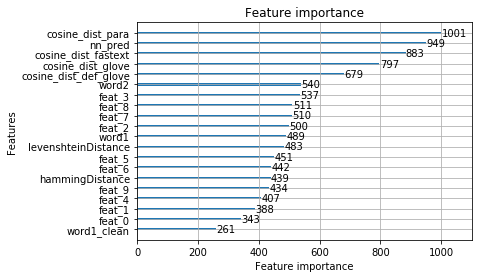

1 LogLoss: 0.1817236558578069
Fold 2/5*1
Training until validation scores don't improve for 150 rounds.
[100]	training's binary_logloss: 0.198078	valid_1's binary_logloss: 0.212948
[200]	training's binary_logloss: 0.156475	valid_1's binary_logloss: 0.183136
[300]	training's binary_logloss: 0.135004	valid_1's binary_logloss: 0.174155
[400]	training's binary_logloss: 0.12044	valid_1's binary_logloss: 0.171401
[500]	training's binary_logloss: 0.108861	valid_1's binary_logloss: 0.170938
[600]	training's binary_logloss: 0.0983897	valid_1's binary_logloss: 0.170685
[700]	training's binary_logloss: 0.0895401	valid_1's binary_logloss: 0.171107
[800]	training's binary_logloss: 0.0814275	valid_1's binary_logloss: 0.17145
Early stopping, best iteration is:
[662]	training's binary_logloss: 0.0929218	valid_1's binary_logloss: 0.170429
2 LogLoss: 0.1704293600892771
Fold 3/5*1
Training until validation scores don't improve for 150 rounds.
[100]	training's binary_logloss: 0.198009	valid_1's binary_log

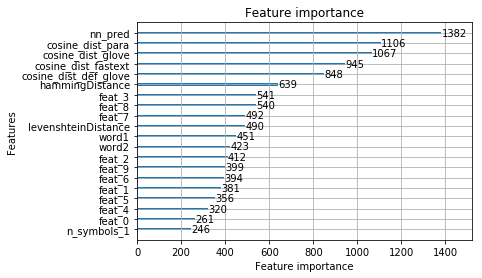

1 LogLoss: 0.18117674759109056
Fold 2/5*1
Training until validation scores don't improve for 150 rounds.
[100]	training's binary_logloss: 0.187502	valid_1's binary_logloss: 0.210044
[200]	training's binary_logloss: 0.1432	valid_1's binary_logloss: 0.181241
[300]	training's binary_logloss: 0.120615	valid_1's binary_logloss: 0.173424
[400]	training's binary_logloss: 0.10562	valid_1's binary_logloss: 0.171165
[500]	training's binary_logloss: 0.094176	valid_1's binary_logloss: 0.170912
[600]	training's binary_logloss: 0.0844595	valid_1's binary_logloss: 0.171127
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.0923575	valid_1's binary_logloss: 0.170755
2 LogLoss: 0.1707552133963106
Fold 3/5*1
Training until validation scores don't improve for 150 rounds.
[100]	training's binary_logloss: 0.187305	valid_1's binary_logloss: 0.214024
[200]	training's binary_logloss: 0.142645	valid_1's binary_logloss: 0.184905
[300]	training's binary_logloss: 0.119559	valid_1's binary_loglo

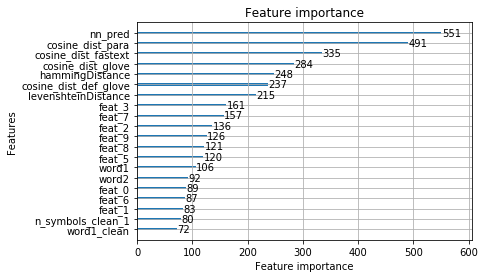

1 LogLoss: 0.17952475258265357
Fold 2/5*1
Training until validation scores don't improve for 150 rounds.
[100]	training's binary_logloss: 0.219348	valid_1's binary_logloss: 0.218782
[200]	training's binary_logloss: 0.188254	valid_1's binary_logloss: 0.188085
[300]	training's binary_logloss: 0.175722	valid_1's binary_logloss: 0.177418
[400]	training's binary_logloss: 0.168861	valid_1's binary_logloss: 0.173392
[500]	training's binary_logloss: 0.164176	valid_1's binary_logloss: 0.171943
[600]	training's binary_logloss: 0.160378	valid_1's binary_logloss: 0.171366
[700]	training's binary_logloss: 0.157049	valid_1's binary_logloss: 0.17103
[800]	training's binary_logloss: 0.153765	valid_1's binary_logloss: 0.170805
[900]	training's binary_logloss: 0.150855	valid_1's binary_logloss: 0.171029
Early stopping, best iteration is:
[784]	training's binary_logloss: 0.154224	valid_1's binary_logloss: 0.170746
2 LogLoss: 0.17074621578621954
Fold 3/5*1
Training until validation scores don't improve fo

In [163]:
import matplotlib.pyplot as plt
%matplotlib inline

pr = []
for lgb_params in param_dicts:
#     lgb_params = {
#         'boosting_type': 'gbdt',
#         'objective': 'binary',
#         'metric': 'binary_logloss',
#         'max_depth': 5,
#         'learning_rate': 0.01, 
#         'verbose': -1,
#         'num_threads': 2,
#         'random_seed': random_seed,
#         'colsample_bytree': 0.8,
#         'subsample': 0.8,
#         'subsample_freq': 1,
#         'min_data_in_leaf': 50
#     }

    # Build the model
    cnt = 0
    p_buf = []
    n_splits = 5
    n_repeats = 1
    kf = KFold(
        n_splits=n_splits, 
        random_state=42)
    err_buf = []   

    n_features = X.shape[1]

    for train_index, valid_index in kf.split(X, y):
        print('Fold {}/{}*{}'.format(cnt + 1, n_splits, n_repeats))
        params = lgb_params.copy() 

        lgb_train = lgb.Dataset(
            X.iloc[train_index], 
            y[train_index], 
            )
        lgb_train.raw_data = None

        lgb_valid = lgb.Dataset(
            X.iloc[valid_index], 
            y[valid_index],
            )
        lgb_valid.raw_data = None

        model = lgb.train(
            params,
            lgb_train,
            num_boost_round=100000,
            valid_sets=[lgb_train, lgb_valid],
            early_stopping_rounds=150, 
            verbose_eval=100,
        )
        if cnt == 0:
            importance = model.feature_importance()
            model_fnames = model.feature_name()
            tuples = sorted(zip(model_fnames, importance), key=lambda x: x[1])[::-1]
            tuples = [x for x in tuples if x[1] > 0]
            print('Important features:')
            for i in range(60):
                if i < len(tuples):
                    print(tuples[i])
                else:
                    break

            del importance, model_fnames, tuples

            lgb.plot_importance(model, max_num_features=20)
            plt.show()


        p = model.predict(X.iloc[valid_index], num_iteration=model.best_iteration)
        err = log_loss(y[valid_index], p)

        print('{} LogLoss: {}'.format(cnt + 1, err))

        p = model.predict(X_test, num_iteration=model.best_iteration)
        if len(p_buf) == 0:
            p_buf = np.array(p, dtype=np.float16)
        else:
            p_buf += np.array(p, dtype=np.float16)
        err_buf.append(err)


        cnt += 1
        # if cnt > 0: # Comment this to run several folds
        #     break

        del model, lgb_train, lgb_valid, p
        gc.collect

    err_mean = np.mean(err_buf)
    err_std = np.std(err_buf)
    print('LogLoss = {:.6f} +/- {:.6f}'.format(err_mean, err_std))
    preds = p_buf/cnt
    pr.append((preds, err_mean))

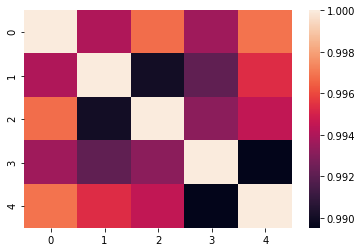

In [164]:
import seaborn as sns

sns.heatmap(np.corrcoef([x[0] for x in pr]))

In [166]:
pr

[(array([0.978 , 0.8647, 0.9873, ..., 0.991 , 0.9893, 0.997 ], dtype=float16),
  0.17794722399349125),
 (array([0.9766, 0.8228, 0.987 , ..., 0.9873, 0.986 , 0.996 ], dtype=float16),
  0.17851520217743005),
 (array([0.9834, 0.875 , 0.9893, ..., 0.992 , 0.9897, 0.997 ], dtype=float16),
  0.17853493335070184),
 (array([0.9844, 0.822 , 0.9907, ..., 0.9907, 0.9907, 0.996 ], dtype=float16),
  0.17858693766169065),
 (array([0.9727, 0.9165, 0.982 , ..., 0.9897, 0.9873, 0.996 ], dtype=float16),
  0.17766515421742213)]

In [167]:
preds = np.mean(np.array([x[0] for x in pr]), axis=0)

In [ ]:
len(pr)

In [168]:
# preds = p_buf/cnt

# Prepare submission
subm = pd.DataFrame()
subm['id'] = id_test
subm['similarity'] = preds
subm.to_csv('submission_lgb_ens.csv', index=False)

In [108]:
subm[subm['similarity'] < 0.2]

id  similarity
10        10    0.023773
148      148    0.066284
300      300    0.035583
308      308    0.038269
362      362    0.075562
365      365    0.154053
436      436    0.035522
462      462    0.161377
545      545    0.065063
749      749    0.109863
1221    1221    0.158447
1605    1605    0.139282
1712    1712    0.063660
1755    1755    0.143311
2071    2071    0.153076
2265    2265    0.081970
2298    2298    0.019730
2408    2408    0.124695
2485    2485    0.079468
2541    2541    0.060547
2553    2553    0.052551
2610    2610    0.175049
2870    2870    0.128174
2979    2979    0.187988
2981    2981    0.081909
3014    3014    0.192749
3153    3153    0.043884
3154    3154    0.042633
3197    3197    0.173950
3518    3518    0.198608
...      ...         ...
18633  18633    0.050232
18670  18670    0.142334
18782  18782    0.182983
19110  19110    0.037781
19191  19191    0.123840
19193  19193    0.068787
19194  19194    0.162842
19480  19480    0.045532
19484  19484    0.108215
19505  19505    0.081177
19874  19874    0.083557
19901  19901    0.082642
19960  19960    0.029007
20222  20222    0.190674
20462  20462    0.027344
20520  20520    0.130737
20537  20537    0.073853
20635  20635    0.058105
20658  20658    0.034546
20667  20667    0.147461
20669  20669    0.099426
21274  21274    0.048889
21279  21279    0.171021
21298  21298    0.033844
21310  21310    0.075806
21566  21566    0.114746
21902  21902    0.133301
21935  21935    0.030884
22022  22022    0.052795
22032  22032    0.119141

[167 rows x 2 columns]